In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import np_utils
import numpy as np
import nnModels
import main

Using Theano backend.
/Users/harveytang/.virtualenvs/eye/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
data = np.load('data/fovealImages.npy')

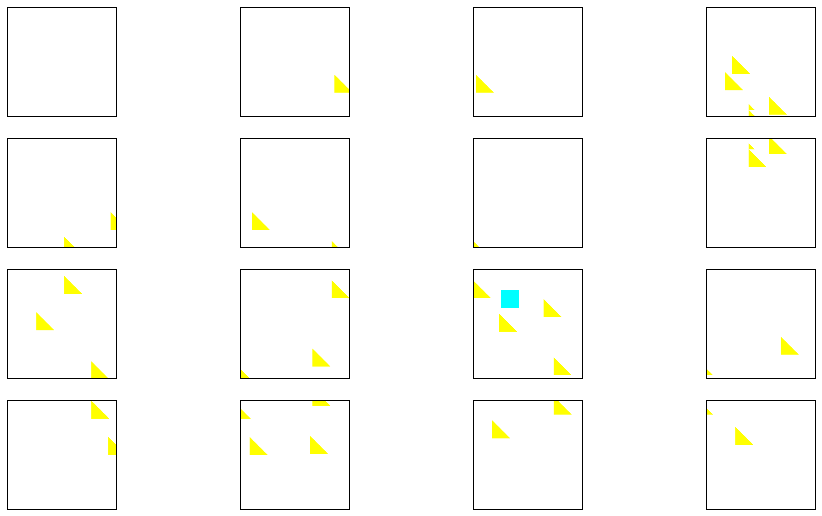

In [28]:
foo = main.splitSectors(data[0])
fig = plt.figure(figsize=(16,9))
for sector_index in range(len(foo)):
    plt.subplot(4,4,sector_index+1)
    bar = main.formRGBImage(foo[sector_index])
    plt.imshow(bar)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',        # ticks along the bottom edge are off
    right='off',       # ticks along the top edge are off
    labelleft='off')   # labels along the bottom edge are off

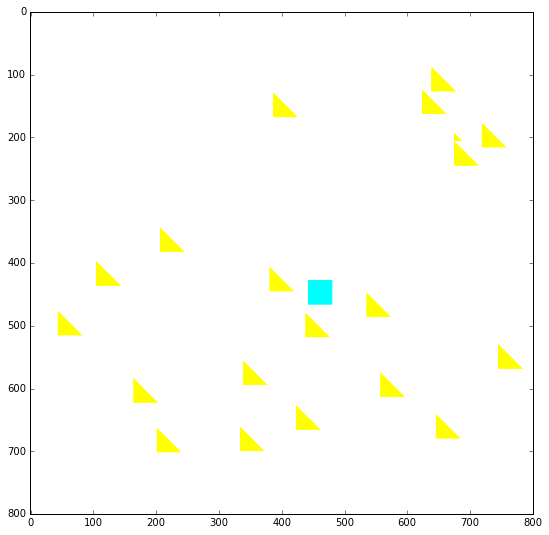

In [27]:
fig = plt.figure(figsize=(16,9))
plt.imshow(main.formRGBImage(data[0]))

In [5]:
peri = nnModels.PeripheryNet()
peri.load('99pBetter_7500')

In [6]:
peri_data = np.load('data/peripheryImages.npy')
peri_answers = np.load('data/peripheryIndexes.npy')
peri_answers = np_utils.to_categorical(peri_answers, 16)

In [7]:
predictions = peri.predict(peri_data[len(data)*3/4:])
right = 0
topHalf = 0
for i, j in enumerate(predictions):
    if np.argmax(j) == np.argmax(peri_answers[i]):
        right += 1
    if np.argmax(peri_answers[i]) in np.argpartition(j, -8)[-8:]:
        topHalf += 1
print("First choice cases: {0}".format(float(right)/len(predictions)))
print("Top half of cases: {0}".format(float(topHalf)/len(predictions)))

First choice cases: 1.0
Top half of cases: 1.0


In [8]:
fovAnswers = np.concatenate(peri_answers[:50])
fovData = np.concatenate([main.splitSectors(datum) for datum in data[:50]])

In [38]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from keras.optimizers import SGD

class FoveaNet(object):
    model = None

    def __init__(self, sample_datum=None):
        # Build model
        fovModel = Sequential()
        fovModel.add(Convolution2D(3, 15, 15, input_shape=sample_datum.shape, init='normal'))
        fovModel.add(Activation('relu'))
        fovModel.add(Dropout(0.2))
        fovModel.add(Convolution2D(3, 7, 7, init='normal'))
        fovModel.add(Activation('relu'))
        fovModel.add(Dropout(0.2))
        fovModel.add(Flatten())
        fovModel.add(Dense(output_dim=1))
        fovModel.add(Activation('sigmoid'))
        fovModel.compile(loss='binary_crossentropy', optimizer='rmsprop')
        self.model = fovModel

    def fit(self, data, answers, nb_epoch=3, batch_size=128):
        self.model.fit(data, answers, nb_epoch=nb_epoch, batch_size=batch_size, show_accuracy=True)

    def predict(self, data):
        return self.model.predict(data)

    def save(self, fname, overwrite=False):
        self.model.save_weights(fname, overwrite=overwrite)

    def load(self, fname):
        self.model.load_weights(fname)

In [39]:
fovModel = FoveaNet(fovData[0])

In [40]:
fovModel.fit(fovData[:len(fovData)*3/4], fovAnswers[:len(fovAnswers)*3/4], nb_epoch=3, batch_size=128)

Epoch 1/3
600/600 [==============================] - 59s - loss: 2.8636 - acc: 1.0000    
Epoch 2/3
600/600 [==============================] - 63s - loss: 0.9939 - acc: 1.0000    
Epoch 3/3
600/600 [==============================] - 62s - loss: 0.9939 - acc: 1.0000    


In [41]:
fovPredictions = fovModel.predict(fovData[len(fovData)*3/4:])

In [42]:
np.max(fovPredictions)

0.0

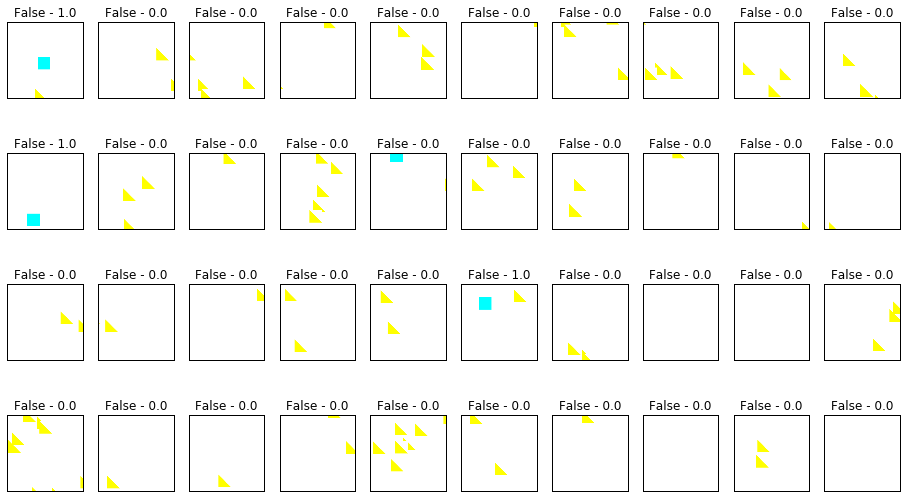

In [35]:
fig = plt.figure(figsize=(16,9))
for pred_index in range(40):
    plt.subplot(4,10,pred_index+1)
    bar = main.formRGBImage(fovData[len(fovData)*3/4:][pred_index])
    plt.imshow(bar)
    plt.title("{0} - {1}".format(fovPredictions[pred_index][0] > 0.5, fovAnswers[len(fovAnswers)*3/4:][pred_index]))
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',        # ticks along the bottom edge are off
    right='off',       # ticks along the top edge are off
    labelleft='off')   # labels along the bottom edge are off